### Importing Simulation and HVAC Data

In [65]:
import pandas as pd
import numpy as np

# Import simulation data
simdat = pd.read_csv("MidPackage_RetrofitResults.csv")
# Import HVAC data
hvac = pd.read_csv("LA_HVAC_results.csv")
print('Pre-merge:','\n',simdat.shape, '\n', hvac.shape)

# Merge dataframes
merged = pd.merge(simdat, hvac, left_on="ubid", right_on="LA_bid")
print("Post-merge:","\n", merged.shape)
merged.head()


Pre-merge: 
 (486, 105) 
 (243, 5)
Post-merge: 
 (486, 110)


,building id,building name,user defined building id,ubid,building type,year built (year),height (m),number of stories,total floor area (m2),baseline annual site energy use intensity (kWh/m2),...,Applicable ECM name 18,Applicable ECM ID 19,Applicable ECM name 19,Applicable ECM ID 20,Applicable ECM name 20,citybes_id,LA_bid,HVAC_system_type,number_of_HVAC_units,average_cooling_capacity_per_HVAC_unit(kW)
0,7622814,NaN,NaN,390574910969,Large Office,1984,9.34,3,22656.0624,185.8748,...,NaN,NaN,NaN,NaN,NaN,7622814,390574910969,central chiller + boiler (VAV with reheat),1,2076.961865
1,7622814,NaN,NaN,390574910969,Large Office,1984,9.34,3,22656.0624,185.8748,...,NaN,NaN,NaN,NaN,NaN,7622814,390574910969,central chiller + boiler (VAV with reheat),1,2076.961865
2,7622813,NaN,NaN,496795871774,Multi Family House,1971,13.71,4,5214.8184,100.9181,...,NaN,NaN,NaN,NaN,NaN,7622813,496795871774,split system air conditioner+gas furnace - eac...,48,4.762106
3,7622813,NaN,NaN,496795871774,Multi Family House,1971,13.71,4,5214.8184,100.9181,...,NaN,NaN,NaN,NaN,NaN,7622813,496795871774,split system air conditioner+gas furnace - eac...,48,4.762106
4,7622824,NaN,NaN,378562887758,Large Office,1981,14.74,5,10631.4600,197.9038,...,NaN,NaN,NaN,NaN,NaN,7622824,378562887758,central chiller + boiler (VAV with reheat),1,1240.109131


In [66]:
# Selecting only buidlings from Simulation
merged = merged[merged['retrofit package name'] == "ECM Package 1"]
# Selecting only multi-family housing
merged = merged[merged["building type"] == "Multi Family House"]
merged.shape

(118, 110)

## Regression Model

In [67]:
import patsy                           # provides a syntax for specifying models  
import statsmodels.api as sm           # provides statistical models like ols, gmm, anova, etc...
import statsmodels.formula.api as smf  # provides a way to directly spec models from formulas

In [68]:
# Renaming variables
merged = merged.rename(columns={"year built (year)": "year_built", 
                                "total floor area (m2)": "floor_area", 
                                "baseline annual site energy use intensity (kWh/m2)": "site_eui",
                                "baseline annual water for water systems (m3/m2)": "annual_water"})

# Changing units
merged["annual_water"] = merged["annual_water"]*merged["floor_area"]
merged["annual_water"] = merged["annual_water"]*264.172
merged["floor_area"] = merged["floor_area"]*10.7639
merged["annual_water"]=merged["annual_water"]/merged["floor_area"]

In [92]:
simdata = merged[["number_of_HVAC_units","year_built","floor_area","site_eui", "annual_water"]]

# Adding year_built indicators
simdata["post1980"] = 0
simdata.loc[(simdata['year_built'] >= 1980), 'post1980'] = 1

# Scaling the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(simdata[["floor_area","site_eui","annual_water"]])
simdata[["floor_area","site_eui","annual_water"]] = scaler.transform(simdata[["floor_area","site_eui","annual_water"]])

<ipython-input-92-d168510cc555>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simdata["post1980"] = 0
/Users/owner/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-92-d168510cc555>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

In [93]:
simdata.head()

,number_of_HVAC_units,year_built,floor_area,site_eui,annual_water,post1980
3,48,1971,0.099798,0.463820,0.165269,0
9,64,1969,0.096850,0.475176,0.217759,0
11,75,1971,0.156731,0.351933,0.214793,0
23,39,1986,0.058442,0.405358,0.178111,1
25,15,1986,0.014625,0.653063,0.409638,1


In [112]:
# Regression model
res = smf.ols('number_of_HVAC_units ~ floor_area + np.power(floor_area,2) + post1980 + site_eui + annual_water -1', data=simdata).fit()
print(res.summary())

                                  OLS Regression Results                                 
Dep. Variable:     number_of_HVAC_units   R-squared (uncentered):                   0.946
Model:                              OLS   Adj. R-squared (uncentered):              0.944
Method:                   Least Squares   F-statistic:                              396.1
Date:                  Tue, 23 Mar 2021   Prob (F-statistic):                    7.10e-70
Time:                          20:51:27   Log-Likelihood:                         -568.37
No. Observations:                   118   AIC:                                      1147.
Df Residuals:                       113   BIC:                                      1161.
Df Model:                             5                                                  
Covariance Type:              nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
--------

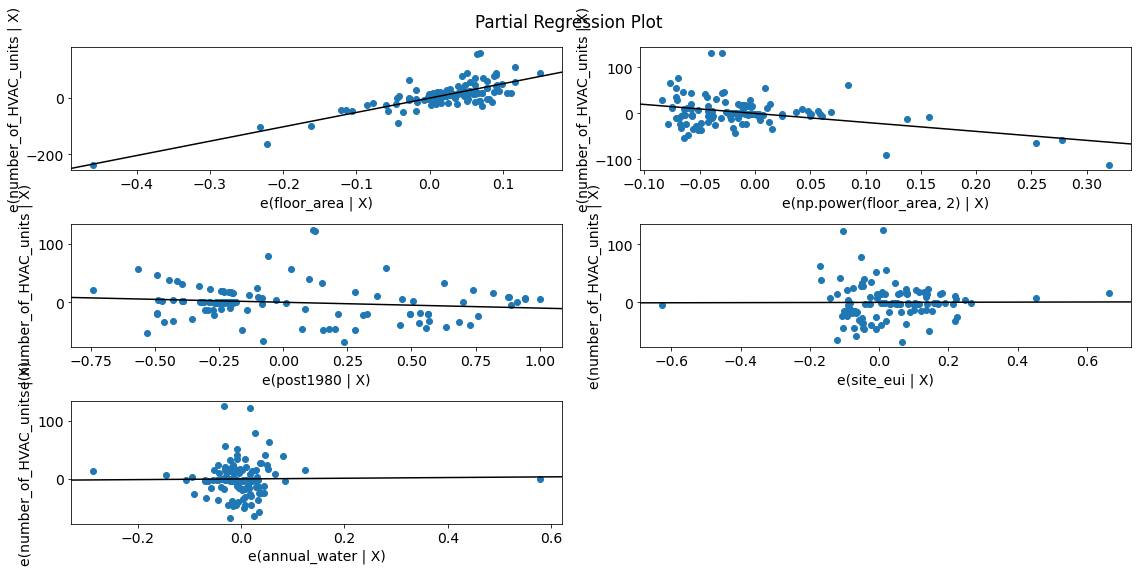

In [113]:
import matplotlib.pyplot as plt

plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

fig = sm.graphics.plot_partregress_grid(res)
fig.tight_layout(pad=1.0)

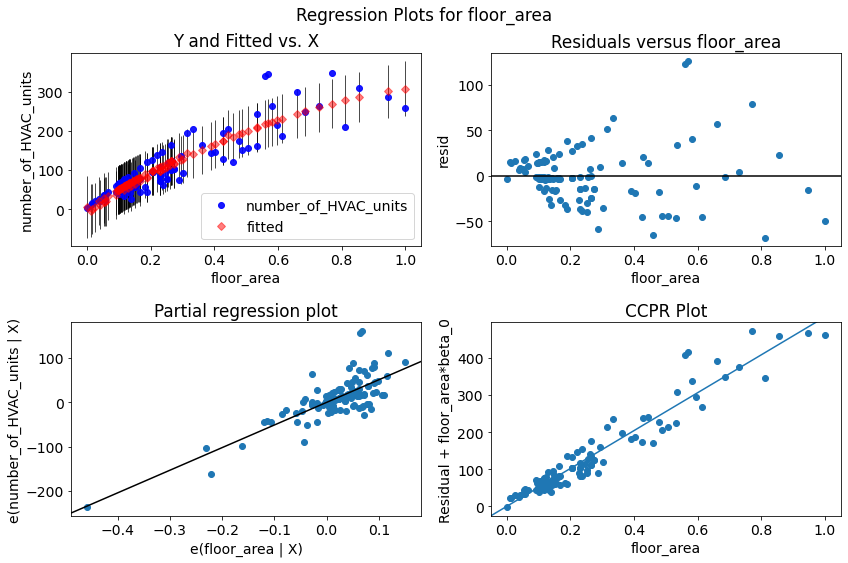

In [106]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(res, 'floor_area', fig=fig)

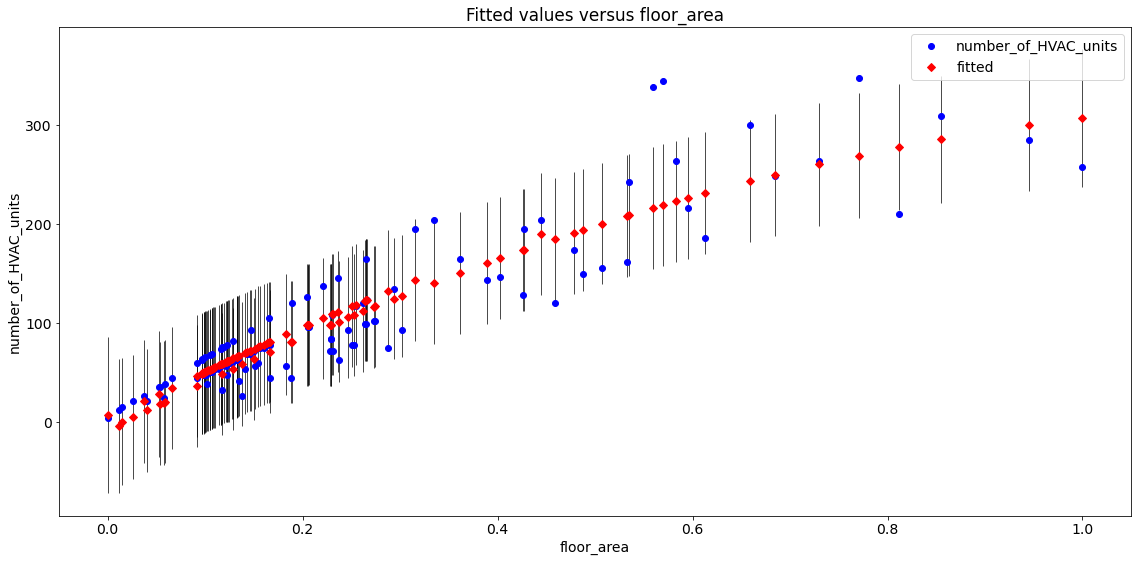

In [119]:
fig = sm.graphics.plot_fit(res, "floor_area")
fig.tight_layout(pad=1.0)

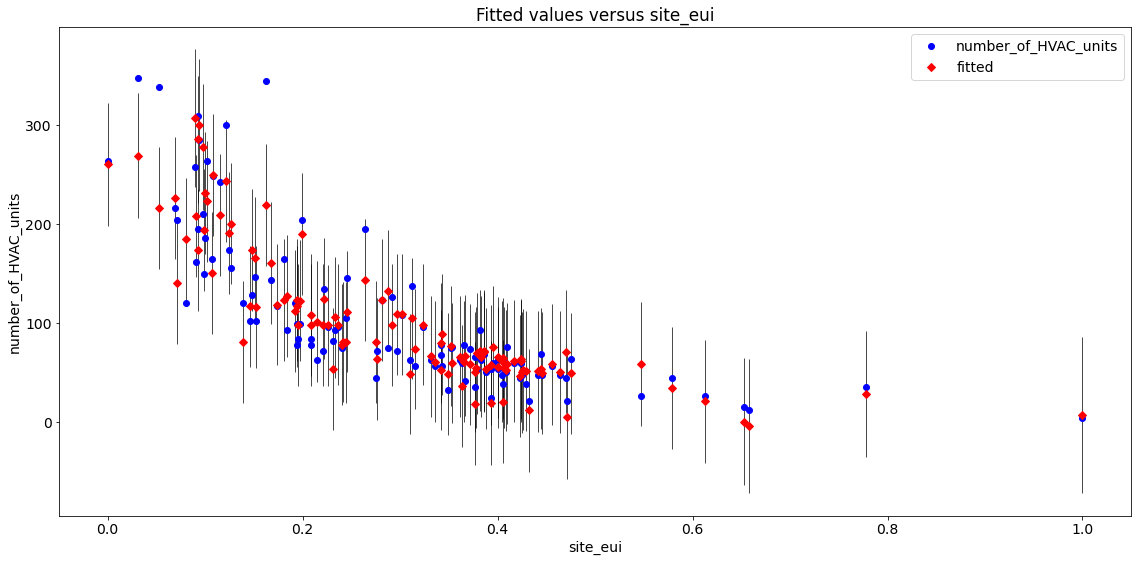

In [120]:
fig = sm.graphics.plot_fit(res, "site_eui")
fig.tight_layout(pad=1.0)

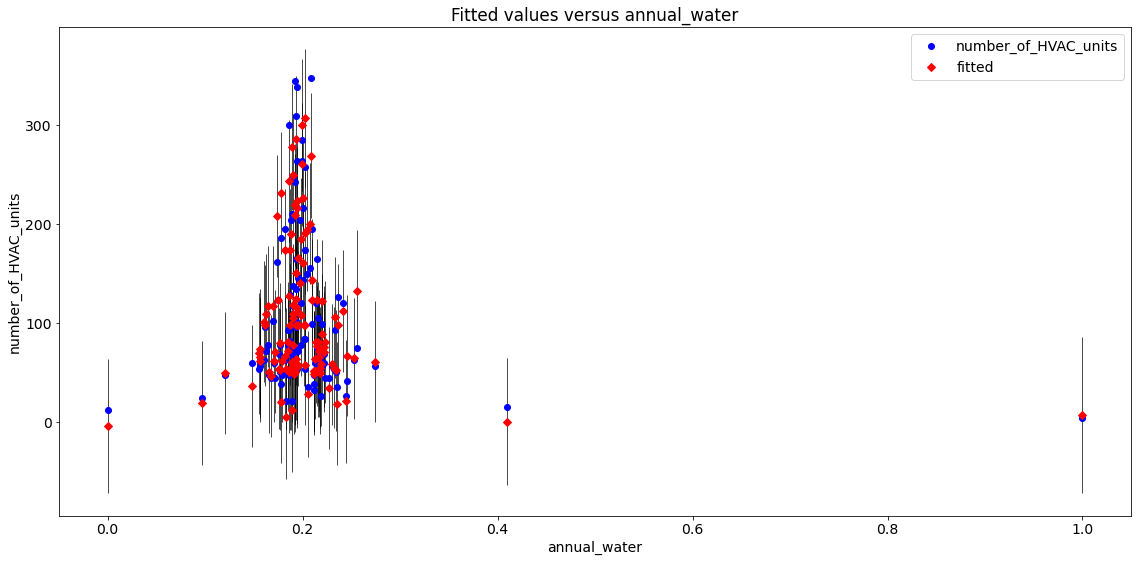

In [121]:
fig = sm.graphics.plot_fit(res, "annual_water")
fig.tight_layout(pad=1.0)

### Importing EBEWE Data

In [96]:
EBEWE_buildings = pd.read_csv("Building_Data.csv") 
EBEWE_buildings = EBEWE_buildings.replace('Not Available',np.NaN)
EBEWE_buildings = EBEWE_buildings.replace('',np.NaN)
EBEWE_buildings = EBEWE_buildings.replace(' ',np.NaN)
display(EBEWE_buildings.head())

unique = EBEWE_buildings.drop_duplicates('BUILDING.ID') # unique builing IDs 

,Census.Tract.GEOID,BUILDING.ID,BUILDING.ADDRESS,CARBON.DIOXIDE.EMISSIONS,COMPLIANCE.STATUS,X.DIFFERENCE.SOURCE.EUI,X.DIFFERENCE.SITE.EUI,ENERGY.STAR.SCORE,ENERGY.STAR.CERTIFICATION.ELIGIBILITY,ENERGY.STAR.CERTIFICATION.LAST.APPROVAL.DATE,...,YEAR.BUILT,AIN,LADBS.Building.Category,CityOwned,Building.Wave,Longitude,Latitude,CES.Score,CES.Score.Percentile,Disadvantaged.Community
0,6.037101e+09,472648918081,10655 TUJUNGA CANYON BLVD,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,025,"20,000 to 49,999",0,1,-118.29406,34.262585,22.670607,44.457056,0.0
1,6.037101e+09,474608916272,10356 COMMERCE AVE,102.2,1,-11.2,-11.2,69.0,0.0,NaN,...,1983.0,081,"20,000 to 49,999",0,2,-118.28859,34.257057,22.670607,44.457056,0.0
2,6.037101e+09,472648918081,10655 TUJUNGA CANYON BLVD,64.8,1,-43.6,-43.6,100.0,0.0,NaN,...,1982.0,025,"20,000 to 49,999",0,1,-118.29406,34.262585,22.670607,44.457056,0.0
3,6.037101e+09,470655916534,7771 W FOOTHILL BLVD,34.3,1,-9.5,-9.5,NaN,0.0,NaN,...,1995.0,901,"7,500 to 14,999",1,3,-118.30181,34.258247,22.670607,44.457056,0.0
4,6.037101e+09,473833915711,10304 TUJUNGA CANYON BLVD,NaN,0,NaN,NaN,NaN,NaN,NaN,...,NaN,057,"20,000 to 49,999",0,1,-118.29106,34.256090,22.670607,44.457056,0.0


In [97]:
# Select only medium multi-family 
multi_medium = unique[(unique["PROPERTY.TYPE"]=="Multifamily Housing") & 
                      (unique["LADBS.Building.Category"]=="50,000 to 99,999")]

multi_medium_selection = multi_medium[(multi_medium["YEAR.BUILT"] < 1990) & 
                                      (multi_medium["YEAR.BUILT"] > 1970) & 
                                      (multi_medium["GROSS.BUILDING.FLOOR.AREA"] > 50000) & 
                                      (multi_medium["GROSS.BUILDING.FLOOR.AREA"] < 100000)]
multi_medium_selection.shape

(151, 36)

In [98]:
# Renaming columns to match previous names
multi_medium_selection = multi_medium_selection.rename(columns={"YEAR.BUILT": "year_built", 
                                                                "GROSS.BUILDING.FLOOR.AREA": "floor_area", 
                                                                "SITE.EUI": "site_eui",
                                                                "TOTAL.WATER.USE": "annual_water"})

# Changing units
multi_medium_selection["annual_water"] = (multi_medium_selection["annual_water"]*1000)/multi_medium_selection['floor_area']

# Selecting regression x_variables
xvariables = multi_medium_selection[["year_built", "floor_area", "annual_water", "site_eui"]]

# Add indicator variables as abvove
xvariables["post1980"] = 0
xvariables.loc[(xvariables['year_built'] >= 1980), 'post1980'] = 1

# Scale data
scaler = MinMaxScaler()
scaler.fit(xvariables[["floor_area","site_eui","annual_water"]])
xvariables[["floor_area","site_eui","annual_water"]] = scaler.transform(xvariables[["floor_area","site_eui","annual_water"]])
xvariables = xvariables.drop(columns=["year_built"])

<ipython-input-98-a89dfc40a88b>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  xvariables["post1980"] = 0
/Users/owner/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
<ipython-input-98-a89dfc40a88b>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [99]:
# Predicting # of HVAC Units
xvariables['predicted_HVAC_units'] = res.predict(xvariables)
pd.set_option('display.max_rows', 100)
xvariables[0:100]

,floor_area,annual_water,site_eui,post1980,predicted_HVAC_units
157,0.290446,0.419220,0.423858,1,121.901918
425,0.785599,0.258837,0.494924,1,267.205145
692,0.002900,0.753172,0.011421,1,5.604847
693,0.076190,0.529617,0.519036,1,31.413420
836,0.142313,0.805360,0.425127,0,74.736257
854,0.267805,0.822138,0.562183,1,114.411418
1111,0.478539,0.502576,0.157360,1,192.174456
1428,0.445395,0.592022,0.479695,1,177.758044
1587,0.579898,0.661390,0.573604,0,228.684142
1659,0.980590,0.446407,0.214467,1,307.350760


## kNN Imputation

In [100]:
#simdata = merged[["number_of_HVAC_units","year_built","floor_area","site_eui", "annual_water"]]
x = simdata.drop(columns=["number_of_HVAC_units"])
y = simdata["number_of_HVAC_units"]

In [101]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(x,y)

KNeighborsClassifier(n_neighbors=3)

In [102]:
neigh.predict(xvariables.dropna())

array([51, 51, 57, 51, 57, 57, 57, 51, 57, 51, 51, 36, 57, 51, 57, 51, 51,
       51, 57, 51, 57, 36, 57, 63, 57, 57, 60, 51, 57, 57, 57, 51, 57, 51,
       57, 57, 57, 57, 36, 51, 57, 60, 57, 51, 60, 57, 51, 51, 51, 51, 51,
       51, 57, 51, 36, 51, 51, 51, 51, 51, 51, 51, 57, 51, 60, 51, 57, 57,
       51, 63, 51, 51, 51, 60, 51, 57, 51, 51, 51, 57, 51, 51, 51, 51, 51,
       57, 51, 57, 51, 51, 51, 51, 36, 51, 57, 51, 51, 51, 51, 57, 57, 51,
       63, 51, 57, 63, 57, 57, 57, 51, 57, 51, 57, 51, 63, 51, 51, 51, 51,
       51, 57, 63, 36, 60, 57, 57, 63, 51, 51, 57, 51, 51, 51, 57, 57, 51,
       51, 57, 36, 57, 51, 51, 51, 51, 57])